In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- User level features (row per user, timestamp):
    - `userId`
    - `timestamp`
    - `months_since_account_creation`
    - `display_name_is_null` (careful this isn't a leak!)
    - `website_url_is_null`
    - `about_me_length`
    - `location_is_null`
    - `num_engage`
    - `weeks_since_last_badge`
    - `badge_score`: sum of log(1 / badge_incidence) -- captures a total of engage weighted by their rarity. Eg: let's say a user has two engage, one that 5% of users have and another that 1% of users have, then the badge_score is log(20) + log(100)

- Post level features (row per user, timestamp, postid for posts created before timestamp) - for later aggregation:
    - `userId`
    - `timestamp`
    - `postId`
    - `post_type`
    - `post_rank`: to sort posts by age
    - `has_accepted_ans`: questions only
    - `is_accepted_ans`: answers only
    - `num_tags`: questions only
    - `title_length`: questions only
    - `body_length`
    - `days_since_last_post`
    - `num_postive_votes`
    - `num_negative_votes`
    - `num_comments`
    - `avg_comment_length`
    - `num_distinct_commenters`
    - `avg_commenter_badge_score`


- **Proposed feature set** (row per user, timestamp):
    - `* from user_features`
    - Question feats:
        - last_question (feats as of the last question asked by user, NULL if not exists):
            - `weeks_ago`: how many weeks ago did the user post their last question 
            - `has_accepted_ans`
            - `num_tags`
            - `title_length`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - questions_last_6mo (aggregate feats over questions asked by user in the last 6 months, NULL otherwise):
            - `num_questions_last_6mo`
            - `avg_has_accepted_ans`
            - `avg_num_tags`
            - `avg_title_length`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`
    - Answer feats:
        - last_answer (feats as of the last answer posted by user, NULL if not exists)
            - `weeks_ago`: how many weeks ago did the user post their last answer 
            - `is_accepted_ans`
            - `body_length`
            - `num_postive_votes`
            - `num_negative_votes`
            - `num_comments`
            - `avg_comment_length`
            - `num_distinct_commenters`
            - `avg_commenter_badge_score`
        - answers_last_3mo (aggregate feats over answeres posted by user in the last 3 months, NULL otherwise):
            - `num_answeres_last_3mo`
            - `acceptance_rate`
            - `avg_body_length`
            - `avg_num_postive_votes`
            - `avg_num_negative_votes`
            - `avg_num_comments`
            - `avg_avg_comment_length`
            - `avg_num_distinct_commenters`
            - `avg_commenter_badge_score`

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('stack_exchange/stackex.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('stack_exchange/engage/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=0))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [3]:
utils.validate_feature_tables('engage', conn)

Validating train
train labels size: 1,360,850 x 3
train feats size: 1,360,850 x 56

Validating val
val labels size: 85,838 x 3
val feats size: 85,838 x 56

Validating test
test labels size: 88,137 x 2
test feats size: 88,137 x 55

✅ All tables are valid!


In [4]:
%%sql train_df <<
from engage_train_feats

In [5]:
infer_df_stype(train_df)

{'OwnerUserId': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'contribution': <stype.categorical: 'categorical'>,
 'months_since_account_creation': <stype.numerical: 'numerical'>,
 'display_name_is_null': <stype.categorical: 'categorical'>,
 'website_url_is_null': <stype.categorical: 'categorical'>,
 'about_me_length': <stype.numerical: 'numerical'>,
 'location_is_null': <stype.categorical: 'categorical'>,
 'num_badges': <stype.numerical: 'numerical'>,
 'badge_score': <stype.numerical: 'numerical'>,
 'weeks_since_last_comment': <stype.numerical: 'numerical'>,
 'num_comments': <stype.numerical: 'numerical'>,
 'num_posts_commented': <stype.numerical: 'numerical'>,
 'avg_comment_length': <stype.numerical: 'numerical'>,
 'last_q_weeks_ago': <stype.numerical: 'numerical'>,
 'last_q_has_accepted_ans': <stype.categorical: 'categorical'>,
 'last_q_num_tags': <stype.categorical: 'categorical'>,
 'last_q_title_length': <stype.categorical: 'categorical'>,
 'last_q

In [7]:
utils.feature_summary_df(train_df.sample(20_000), 'contribution', classification=True)

,Label Corr.,Label MI,NaN %
weeks_since_last_comment,-0.232,0.041,39.6%
num_posts_commented,0.169,0.034,0.0%
num_comments,0.166,0.032,0.0%
avg_num_comments_a,0.078,0.032,94.5%
avg_num_positive_votes_a,0.108,0.030,94.5%
badge_score,0.234,0.029,0.0%
num_answers_last_6mo,0.325,0.028,94.5%
avg_num_distinct_commenters_a,0.078,0.028,94.5%
ans_acceptance_rate,0.133,0.027,94.5%
last_a_weeks_ago,-0.260,0.027,72.1%


## Feature Importances

In [8]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-stack-user-engagement'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
%%sql val_df <<
select * from engage_val_feats;

In [10]:
col_to_stype = task_to_stypes[TASK].copy()
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [11]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


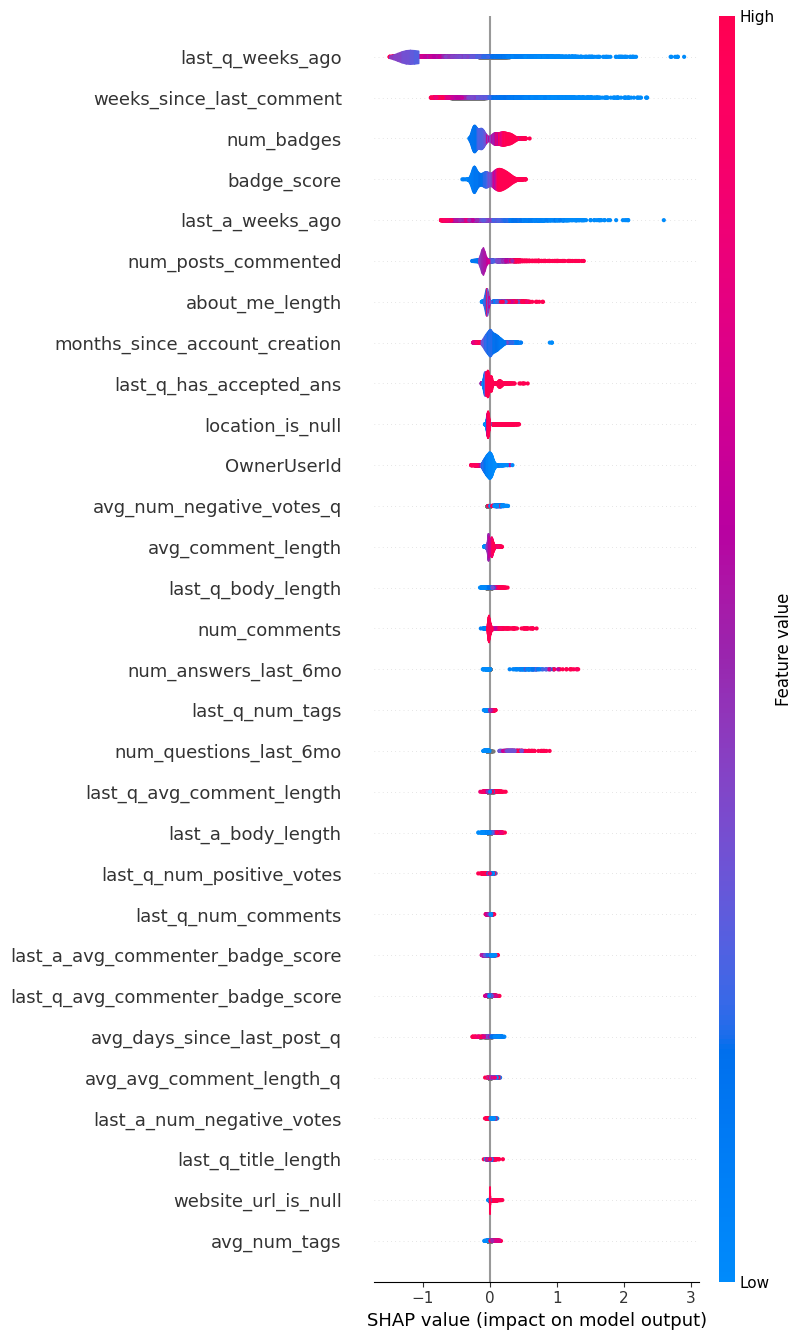

In [12]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

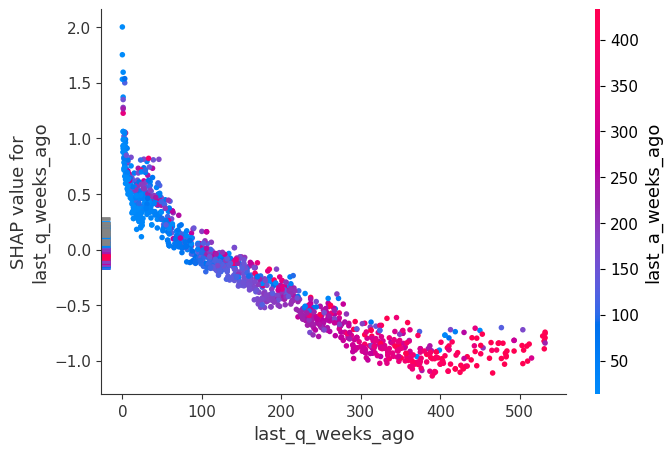

In [13]:
shap.dependence_plot('last_q_weeks_ago', shap_values, val_arr, feature_names=feat_names)

In [14]:
conn.close()